# Исследование объявлений о продаже квартир

Нужно определить рыночную стоимость объектов недвижимости по данным сервиса Яндекс.Недвижимость — архиву объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла  <a class="anchor" id="Изучение-данных-из-файла"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = None

df = pd.read_csv('real_estate_data.csv', sep = '\t')
    
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице 22 столбца, во многих есть пропущенные значения, больше всего пропусков в столбце `is_apartment`. Присутствуют данные 4 типов: `int`, `float`, `object`, `bool`.

## Предобработка данных <a class="anchor" id="Предобработка-данных"></a>

Для начала стоит привести к единому формату названия столбцов.

In [3]:
df = df.rename(columns = {'cityCenters_nearest': 'city_centers_nearest', 'studio':'is_studio'})

In [4]:
df['last_price'].value_counts()

4500000.0     342
3500000.0     291
4000000.0     260
4300000.0     260
4200000.0     259
             ... 
10430000.0      1
9917600.0       1
3180500.0       1
7297000.0       1
4386000.0       1
Name: last_price, Length: 2978, dtype: int64

В столбце `last_price` все данные типа `float`, хотя дробных значений нет. Можно привести к типу `int`.

In [5]:
df['last_price'] = df['last_price'].astype('int')

Приведение даты к нормальному виду:

In [6]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [7]:
df['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Из столбца `rooms` видно, что есть 197 значений 0 для комнат. Вероятно это ошибка, стоит поставить хотя бы 1 комнату.

In [8]:
df.loc[df['rooms'] == 0, 'rooms'] = 1

Первый столбец с пропущенными значениями - `ceiling_height`. Скорее всего при вводе данных пункт с высотой потолков был необязательным, поэтому люди их не указывали, что привело к появлению пропусков.

In [9]:
df['ceiling_height'].isna().sum()

9195

In [10]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = (df.groupby('floor')['ceiling_height'].transform('median'))

Пропуски в столбце `ceiling_height` можно заменить на медиану среди всех значений столбца floor. Оставшиеся 4 пропуска стоит заменить средним значением.

In [11]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].mean()
df['ceiling_height'] = round(df['ceiling_height'], 2)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.60,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.60,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Далее идет столбец `floors_total`.

In [12]:
(df['floors_total'].isna().sum())
df.loc[df['floors_total'].isna(), 'floors_total'] = (df.groupby('floor')['floors_total'].transform('mean'))
df['floors_total'] = np.ceil(df['floors_total']).astype('int')

86

Пропуски в столбце `floors_total` можно заменить на среднее среди всех значений столбца `floor`, округленное в большую сторону. Вероятно пропуски появились из-за неправильного ввода количества этажей, либо же этот пункт был опциональным. Также количество этажей - это всегда целое число, поэтому `float` необходимо преобразовать.

Пропуски в столбцах `living_area`, `kitchen_area` можно заменить на среднее среди всех значений столбца `total_area`. Это очень важные пункты в объявлении, поэтому пропуски могли появиться в результате неправильной обработки данных.

In [13]:
print('living_area:', df['living_area'].isna().sum(), '   kitchen_area:', df['kitchen_area'].isna().sum())

living_area: 1903    kitchen_area: 2278


In [14]:
df.loc[df['living_area'].isna(), 'living_area'] = df.groupby('total_area')['living_area'].transform('mean')
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df.groupby('total_area')['kitchen_area'].transform('mean')
print('living_area:', df['living_area'].isna().sum(), '   kitchen_area:', df['kitchen_area'].isna().sum())

living_area: 143    kitchen_area: 205


Конечно, не для всех значений столбца `total_area` можно найти среднее, поэтому в некоторых местах пропуски остались.

In [15]:
df['is_apartment'].value_counts(dropna = False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

В столбце `is_apartment` очень много пропусков и значений `False`. Вероятно вводился не булев тип данных, что привело к ошибке и пропускам, которые не ясно чем заменить.

In [16]:
df['balcony'].value_counts(dropna = False)

NaN    11519
1.0     4195
0.0     3758
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

А в столбце `balcony` пропущенные значения вероятно означают остутствие балконов, поэтому пропуски следует заменить на 0. Пропущенные значения скорее всего связаны с неправильным вводом.

In [17]:
df.loc[df['balcony'].isna(), 'balcony'] = 0

Также стоит заменить `float` на `int`.

In [18]:
df['balcony'] = df['balcony'].astype('int')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.60,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.60,14,80.2,9,NaN,False,False,16.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В столбце `locality_name` всего 49 пропусков, которые нечем заменить. Вероятно неправильно введены данные. Также можно убрать неявные дубликаты, повторяющие одни и те же названия. 

In [19]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')
display(df['locality_name'].value_counts().head(30))

Санкт-Петербург              15721
поселок Мурино                 556
поселок Шушары                 440
Всеволожск                     398
Пушкин                         369
Колпино                        338
поселок Парголово              327
Гатчина                        307
деревня Кудрово                299
Выборг                         237
Петергоф                       201
Сестрорецк                     183
Красное Село                   178
Кудрово                        173
деревня Новое Девяткино        144
Сертолово                      142
Ломоносов                      133
Кириши                         125
поселок Бугры                  114
Сланцы                         112
Волхов                         111
Тосно                          104
Кингисепп                      104
Кронштадт                       96
Никольское                      93
Коммунар                        89
Сосновый Бор                    87
Кировск                         84
Отрадное            

In [20]:
df['airports_nearest'].describe(percentiles = [.02, .5, .98])

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
2%       10130.080000
50%      26726.000000
98%      54337.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Так как большинство значений столбца `airports_nearest` находятся в диапазоне 10000 - 55000 метров, то для пропусков можно взять среднее. Также в столбцах используются значения в метрах, которые лучше преобразовать к целым числам.

In [21]:
df.loc[df['airports_nearest'].isna(), 'airports_nearest'] = (df['airports_nearest'].mean())
df['airports_nearest'].isna().sum()
df['airports_nearest'] = df['airports_nearest'].astype('int')

0

Аналогичную замену можно провести со столбцами `city_centers_nearest`, `parks_nearest`, `ponds_nearest`.

In [22]:
df[['city_centers_nearest', 'parks_nearest', 'ponds_nearest']].describe(percentiles = [.02, .5, .98])

,city_centers_nearest,parks_nearest,ponds_nearest
count,18180.000000,8079.000000,9110.000000
mean,14191.277833,490.804555,517.980900
std,8608.386210,342.317995,277.720643
min,181.000000,1.000000,13.000000
2%,2117.320000,41.000000,55.000000
50%,13098.500000,455.000000,502.000000
98%,35511.000000,1514.000000,1086.820000
max,65968.000000,3190.000000,1344.000000


In [23]:
df.loc[df['city_centers_nearest'].isna(), 'city_centers_nearest'] = (df['city_centers_nearest'].mean())
df.loc[df['parks_nearest'].isna(), 'parks_nearest'] = (df['parks_nearest'].mean())
df.loc[df['ponds_nearest'].isna(), 'ponds_nearest'] = (df['ponds_nearest'].mean())
df['city_centers_nearest'] = df['city_centers_nearest'].astype('int')
df['parks_nearest'] = df['parks_nearest'].astype('int')
df['ponds_nearest'] = df['ponds_nearest'].astype('int')
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.000000,8,NaN,False,False,25.00,0,Санкт-Петербург,18863,16028,1.0,482,2.0,755,NaN
1,7,3350000,40.40,2018-12-04,1,2.60,11,18.600000,1,NaN,False,False,11.00,2,поселок Шушары,12817,18603,0.0,490,0.0,517,81.0
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,NaN,False,False,8.30,0,Санкт-Петербург,21741,13933,1.0,90,2.0,574,558.0
3,0,64900000,159.00,2015-07-24,3,2.60,14,80.200000,9,NaN,False,False,16.10,0,Санкт-Петербург,28098,6800,2.0,84,3.0,234,424.0
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,NaN,False,False,41.00,0,Санкт-Петербург,31856,8098,2.0,112,1.0,48,121.0
5,10,2890000,30.40,2018-09-10,1,2.60,12,14.400000,5,NaN,False,False,9.10,0,городской поселок Янино-1,28793,14191,NaN,490,NaN,517,55.0
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.600000,6,NaN,False,False,14.40,1,поселок Парголово,52996,19143,0.0,490,0.0,517,155.0
7,5,7915000,71.60,2019-04-18,2,2.70,24,42.771429,22,NaN,False,False,18.90,2,Санкт-Петербург,23982,11634,0.0,490,0.0,517,NaN
8,20,2900000,33.16,2018-05-23,1,2.63,27,15.430000,26,NaN,False,False,8.81,0,поселок Мурино,28793,14191,NaN,490,NaN,517,189.0
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,NaN,False,False,6.50,2,Санкт-Петербург,50898,15008,0.0,490,0.0,517,289.0


Данные, находящиеся в столбцах `airports_nearest`, `city_centers_nearest`, `parks_nearest`, `ponds_nearest`, вероятно были необязательными для ввода, поэтому многие их не писали, что привело к пропускам. Еще возможно люди отключили геолокацию, и система не смогла определить расстояние до объектов.

In [24]:
df[(df['parks_around3000'].isna()) & (df['ponds_around3000'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000,30.40,2018-09-10,1,2.60,12,14.40,5,NaN,False,False,9.100000,0,городской поселок Янино-1,28793,14191,NaN,490,NaN,517,55.0
8,20,2900000,33.16,2018-05-23,1,2.63,27,15.43,26,NaN,False,False,8.810000,0,поселок Мурино,28793,14191,NaN,490,NaN,517,189.0
12,10,3890000,54.00,2016-06-30,2,2.60,5,30.00,5,NaN,False,False,9.000000,0,Сертолово,28793,14191,NaN,490,NaN,517,90.0
22,20,5000000,58.00,2017-04-24,2,2.75,25,30.00,15,NaN,False,False,11.000000,2,деревня Кудрово,28793,14191,NaN,490,NaN,517,60.0
30,12,2200000,32.80,2018-02-19,1,2.65,9,16.90,2,NaN,False,False,7.700000,0,Коммунар,28793,14191,NaN,490,NaN,517,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000,62.80,2018-09-18,4,2.50,5,45.50,3,NaN,False,False,5.500000,0,поселок Дзержинского,28793,14191,NaN,490,NaN,517,NaN
23692,2,1350000,30.00,2017-07-07,1,2.65,5,17.50,4,NaN,False,False,6.000000,0,Тихвин,28793,14191,NaN,490,NaN,517,413.0
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.00,4,NaN,False,False,8.500000,0,Тосно,28793,14191,NaN,490,NaN,517,45.0
23696,18,2500000,56.70,2018-02-11,2,2.60,3,29.70,1,NaN,False,False,8.822222,0,село Рождествено,28793,14191,NaN,490,NaN,517,NaN


Видно, что пропуски в столбцах `parks_around3000` и `ponds_around3000` совпадают. Сами пропуски вероятно связаны с отсутствием парков и водоемов, поэтому их можно заменить 0, а также привести к типу `int`. Пропущенные значения могли быть вызваны неправильным вводом.

In [25]:
df.loc[df['parks_around3000'].isna(), 'parks_around3000'] = 0
df.loc[df['ponds_around3000'].isna(), 'ponds_around3000'] = 0
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')

In [26]:
df.loc[df['days_exposition'].isna(), 'days_exposition'] = \
df.groupby(df['first_day_exposition'].dt.year)['days_exposition'].transform('mean')
df['days_exposition'] = df['days_exposition'].astype('int')

В столбце `days_exposition` пропуски можно заменить на среднее среди всех значений столбца `first_day_exposition` по году.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23556 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  is_studio             23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23494 non-null  float64       
 13  balcony         

В таблице много столбцов с пропусками, некоторые из них можно заменить средними или медианными значениями, а некоторые, к сожалению, заменить нельзя, их придется оставить. Таких столбцов всего 4, в 3 из них пропусков очень мало. Также многие типы данных подверглись изменению для экономии времени и памяти. 

## Расчёты и добавление результатов в таблицу <a class="anchor" id="Расчёты-и-добавление-результатов-в-таблицу"></a>

In [28]:
df['price_per_meter'] = df['last_price'] / df['total_area'] # цена квадратного метра

df['exposition_day_name'] = (df['first_day_exposition']).dt.day_name()
df['exposition_month_name'] = (df['first_day_exposition']).dt.month_name()
df['exposition_year'] = (df['first_day_exposition'].dt.year).astype('str')   # день недели, месяц и год публикации объявления

def floors(total):
    floor = total['floor']
    floors_total = total['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    
df['floor_names'] = df.apply(floors, axis = 1) #название этажа квартиры

df['living_total_ratio'] = df['living_area'] / df['total_area'] # отношение жилой площади к общей

df['kitchen_total_ratio'] = df['kitchen_area'] / df['total_area'] # отношение площади кухни к общей

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,exposition_day_name,exposition_month_name,exposition_year,floor_names,living_total_ratio,kitchen_total_ratio
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,30,120370.370370,Thursday,March,2019,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.60,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817,18603,0,490,0,517,81,82920.792079,Tuesday,December,2018,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785.714286,Thursday,August,2015,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,2.60,14,80.2,9,NaN,False,False,16.1,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176.100629,Friday,July,2015,другой,0.504403,0.101258
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000.000000,Tuesday,June,2018,другой,0.320000,0.410000


Добавленные столбцы со значениями более наглядны для понимания и последующего анализа.

## Исследовательский анализ данных <a class="anchor" id="Исследовательский-анализ-данных"></a>

###   Гистограммы для площади, цены, числа комнат, высоты потолков <a class="anchor" id="Гистограммы-для-площади,-цены,-числа-комнат,-высоты-потолков"></a>

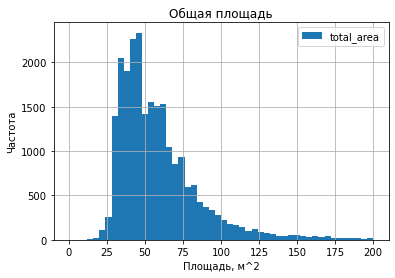

In [29]:
df.plot(kind = 'hist', y = 'total_area', grid = True, bins = 50, range = (0, 200), title = 'Общая площадь');
plt.xlabel('Площадь, м^2'); 
plt.ylabel('Частота'); 
plt.show();

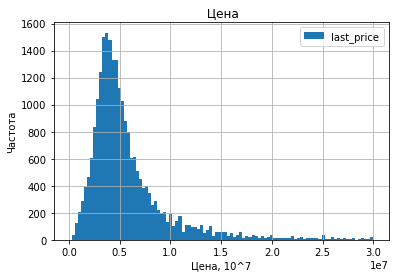

In [30]:
df.plot(kind = 'hist', y = 'last_price', grid = True, bins = 100, range = (0, 0.3e8), title = ' Цена');
plt.xlabel('Цена, 10^7'); 
plt.ylabel('Частота'); 
plt.show();

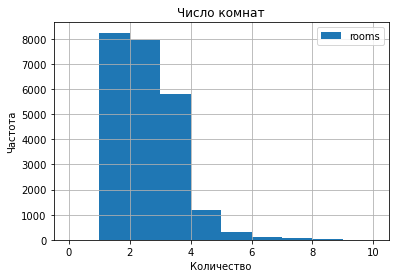

In [31]:
df.plot(kind = 'hist', y = 'rooms', grid = True, bins = 10, range = (0, 10), title = 'Число комнат');
plt.xlabel('Количество'); 
plt.ylabel('Частота'); 
plt.show();

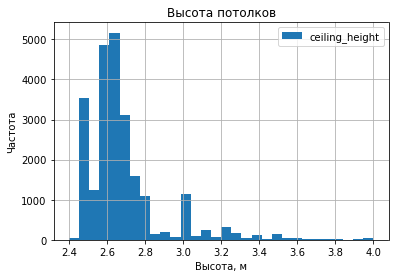

In [32]:
df.plot(kind = 'hist', y = 'ceiling_height', grid = True, bins = 30, range = (2.4, 4), title = 'Высота потолков');
plt.xlabel('Высота, м'); 
plt.ylabel('Частота'); 
plt.show();

Все гистограммы имеют вид распределения Пуассона.

###   Изучение времени продажи квартиры <a class="anchor" id="Изучение-времени-продажи-квартиры"></a>

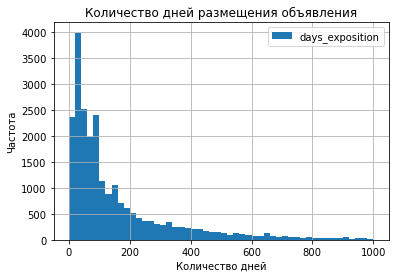

In [33]:
df.plot(kind = 'hist', y = 'days_exposition', grid = True, bins = 50, range = (0, 1000), title = 'Количество дней размещения объявления');
plt.xlabel('Количество дней'); 
plt.ylabel('Частота'); 
plt.show();

In [34]:
df['days_exposition'].describe(percentiles = [.1, .5, .75, .90])
iqr = df['days_exposition'].quantile([0.25,0.5,0.75])[0.75] - df['days_exposition'].quantile([0.25,0.5,0.75])[0.25]

count    23699.000000
mean       168.002743
std        211.597739
min          1.000000
10%         20.000000
50%         92.000000
75%        204.000000
90%        434.200000
max       1580.000000
Name: days_exposition, dtype: float64

По медиане видно, что половина квартир были проданы менее, чем за 3 месяца. 90% квартир продавались чуть больше года. Также больше всего квартир были проданы за 30 дней. Отсюда можно сделать вывод, что быстрее всего квартиры продавались за первые 1 - 3 месяца, медленнее всего продажи шли за более чем 440 дней. 

### Удаление редких и выбивающихся значений <a class="anchor" id="Удаление-редких-и-выбивающихся-значений"></a>

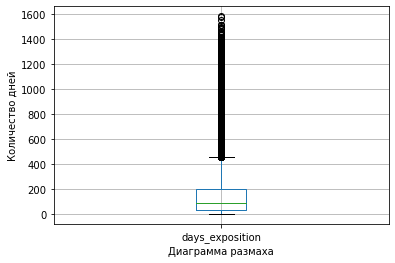

In [35]:
df.boxplot(column = ['days_exposition']);
plt.xlabel('Диаграмма размаха'); 
plt.ylabel('Количество дней'); 

In [36]:
df[ (df['days_exposition'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr > df['days_exposition']) \
   | (df['days_exposition'] > df['days_exposition'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]['days_exposition'].count()

2156

2156 значений столбца `days_exposition` являются выбросами так как не попадают в диапазон [Q1 – 1,5IQR, Q3 + 1,5IQR]. Те же действия необходимо провести с столбцами `last_price`, `total_area`, `rooms`.

In [37]:
df_in_iqr = df[ (df['days_exposition'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df['days_exposition']) \
   & (df['days_exposition'] < df['days_exposition'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]


iqr = df['last_price'].quantile([0.25,0.5,0.75])[0.75] - df['last_price'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df_in_iqr[ (df_in_iqr['last_price'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df_in_iqr['last_price']) \
   & (df_in_iqr['last_price'] < df_in_iqr['last_price'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]

iqr = df['total_area'].quantile([0.25,0.5,0.75])[0.75] - df['total_area'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df_in_iqr[ (df_in_iqr['total_area'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df_in_iqr['total_area']) \
   & (df_in_iqr['total_area'] < df_in_iqr['total_area'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]

iqr = df['rooms'].quantile([0.25,0.5,0.75])[0.75] - df['rooms'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df_in_iqr[ (df_in_iqr['rooms'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df_in_iqr['rooms']) \
   & (df_in_iqr['rooms'] < df_in_iqr['rooms'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]

df_in_iqr # df без выбросов по days_exposition, last_price, total_area, rooms.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,exposition_day_name,exposition_month_name,exposition_year,floor_names,living_total_ratio,kitchen_total_ratio
1,7,3350000,40.4,2018-12-04,1,2.60,11,18.600000,1,NaN,False,False,11.000000,2,поселок Шушары,12817,18603,0,490,0,517,81,82920.792079,Tuesday,December,2018,первый,0.460396,0.272277
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,NaN,False,False,41.000000,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000.000000,Tuesday,June,2018,другой,0.320000,0.410000
5,10,2890000,30.4,2018-09-10,1,2.60,12,14.400000,5,NaN,False,False,9.100000,0,городской поселок Янино-1,28793,14191,0,490,0,517,55,95065.789474,Monday,September,2018,другой,0.473684,0.299342
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.600000,6,NaN,False,False,14.400000,1,поселок Парголово,52996,19143,0,490,0,517,155,99195.710456,Thursday,November,2017,другой,0.284182,0.386059
7,5,7915000,71.6,2019-04-18,2,2.70,24,42.771429,22,NaN,False,False,18.900000,2,Санкт-Петербург,23982,11634,0,490,0,517,30,110544.692737,Thursday,April,2019,другой,0.597366,0.263966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000,30.0,2017-07-07,1,2.65,5,17.500000,4,NaN,False,False,6.000000,0,Тихвин,28793,14191,0,490,0,517,413,45000.000000,Friday,July,2017,другой,0.583333,0.200000
23693,9,4600000,62.4,2016-08-05,3,2.60,9,40.000000,8,NaN,False,False,8.000000,0,Петергоф,45602,34104,1,352,1,675,239,73717.948718,Friday,August,2016,другой,0.641026,0.128205
23695,14,3100000,59.0,2018-01-15,3,2.65,5,38.000000,4,NaN,False,False,8.500000,0,Тосно,28793,14191,0,490,0,517,45,52542.372881,Monday,January,2018,другой,0.644068,0.144068
23696,18,2500000,56.7,2018-02-11,2,2.60,3,29.700000,1,NaN,False,False,8.822222,0,село Рождествено,28793,14191,0,490,0,517,94,44091.710758,Sunday,February,2018,первый,0.523810,0.155595


Так как отрицательных значений нет, то нижняя граница, совпадает с 0, то есть все 2156 значений выходят за рамки верхней границы, равной 457.5. Это означает, что менее 10% квартир (2156) продавалось более 458 дней.

### Факторы, влияющие на стоимость квартиры <a class="anchor" id="Факторы,-влияющие-на-стоимость-квартиры"></a>

In [38]:
df[['last_price', 'total_area', 'rooms', 'city_centers_nearest']].corr()

,last_price,total_area,rooms,city_centers_nearest
last_price,1.000000,0.653675,0.365209,-0.201918
total_area,0.653675,1.000000,0.760233,-0.220446
rooms,0.365209,0.760233,1.000000,-0.171025
city_centers_nearest,-0.201918,-0.220446,-0.171025,1.000000


По таблице корреляции видно, что сильная связь есть только между общей площадью и количеством комнат. Поэтому нет сильной корреляции между ростом цены и площадью, количеством комнат, удалённостью от центра.

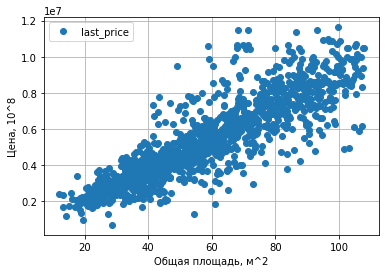

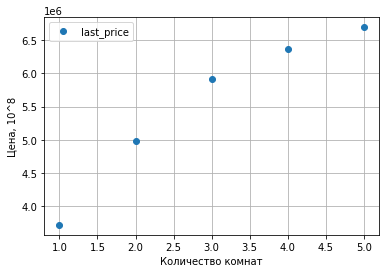

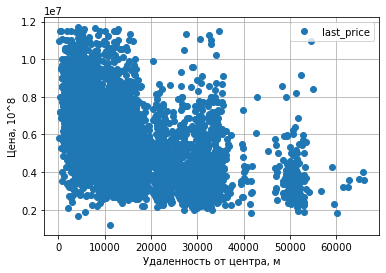

In [39]:
df_in_iqr.pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'mean').plot(style = 'o',  grid=True);
plt.xlabel('Общая площадь, м^2'); 
plt.ylabel('Цена, 10^8'); 
df_in_iqr.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'mean').plot(style = 'o',  grid=True);
plt.xlabel('Количество комнат'); 
plt.ylabel('Цена, 10^8'); 
df_in_iqr.pivot_table(index = 'city_centers_nearest', values = 'last_price', aggfunc = 'mean').plot(style = 'o',  grid=True);
plt.xlabel('Удаленность от центра, м'); 
plt.ylabel('Цена, 10^8'); 

Построив графики по сводным таблицам, можно увидеть, что с ростом площади и количества комнат растет и цена, а также, чем дальше находится недвижимость, тем она дешевле, но не всегда недвижимость рядом с центром дорогая.

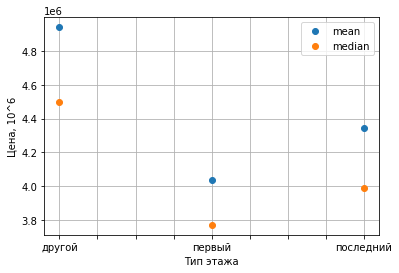

In [40]:
df_in_iqr.pivot_table(index = 'floor_names', values = 'last_price', aggfunc = ['mean', 'median']).plot(style = 'o',  grid=True);
plt.legend(['mean', 'median'])
plt.xlabel('Тип этажа'); 
plt.ylabel('Цена, 10^6'); 

По графику видно, что для среднего и медианы самые низкие значения цены у первого этажа, а самые высокие значения у всех остальных этажей, кроме последних.

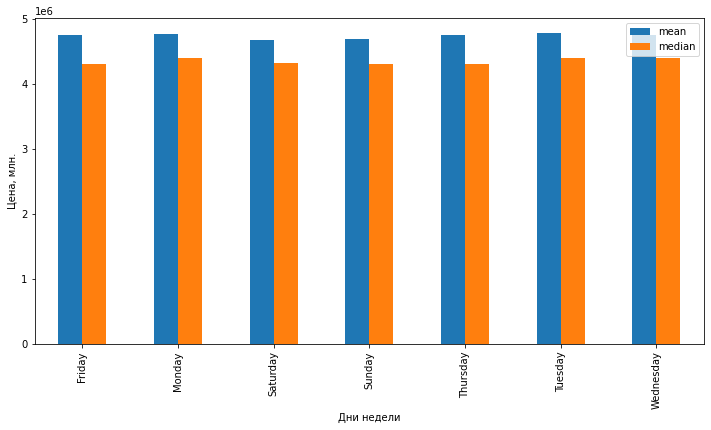

In [41]:
bar_day = df_in_iqr.pivot_table(index = 'exposition_day_name', values = 'last_price', aggfunc = ['mean', 'median']).plot.bar(y=['mean', 'median'], figsize=(12, 6), label = ['mean', 'median'])
plt.xlabel('Дни недели'); 
plt.ylabel('Цена, млн.'); 

Из графика видно только то, что среднее значение цены из объявления, выставленного в выходные дни меньше, чем в остальные.

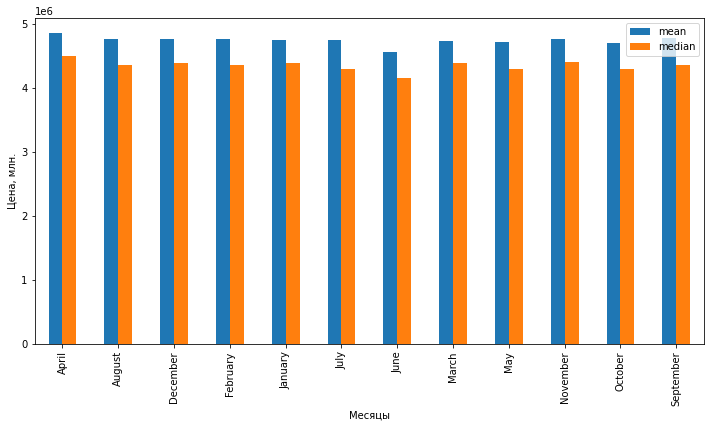

In [42]:
bar_month = df_in_iqr.pivot_table(index = 'exposition_month_name', values = 'last_price', aggfunc = ['median', 'mean']).plot.bar(y=['mean', 'median'], figsize=(12, 6), label = ['mean', 'median'])
plt.xlabel('Месяцы'); 
plt.ylabel('Цена, млн.'); 

Среднее значение цены в апреле и сентябре выше, чем в другие месяцы. Самые маленькие значения среднего и медианы - в июне.

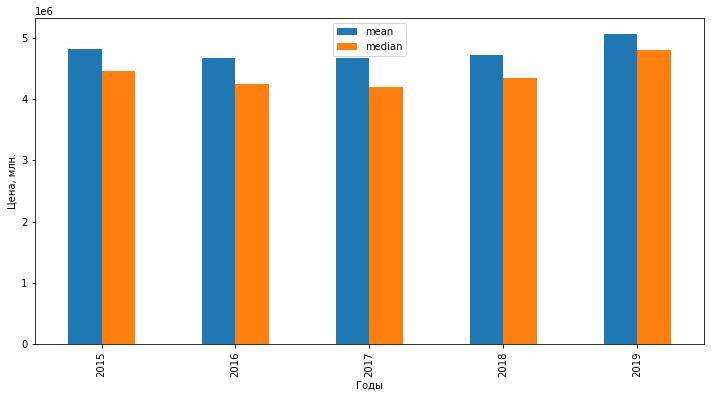

In [43]:
bar_year = df_in_iqr.pivot_table(index = 'exposition_year', values = 'last_price', aggfunc = ['median', 'mean']).plot.bar(y=['mean', 'median'], figsize=(12, 6), label = ['mean', 'median'])
plt.xlabel('Годы'); 
plt.ylabel('Цена, млн.'); 

В 2019 году средняя и медианная цены резко увеличились по сравнению с прошлыми годами.




### 10 населённых пунктов с наибольшим числом объявлений <a class="anchor" id="10-населённых-пунктов-с-наибольшим-числом-объявлений"></a>



In [44]:
top10_locality = pd.DataFrame()
for i in range(len(df_in_iqr['locality_name'].value_counts().head(10).index.tolist())):    
    df1_ = pd.concat([top10_locality, df_in_iqr.loc[df['locality_name'].isin(df_in_iqr['locality_name'].value_counts().head(10).index.tolist())]])
    top10_locality = df1_.copy()
    
top10_locality.pivot_table(index = 'locality_name', values = 'price_per_meter', aggfunc = 'mean').sort_values('price_per_meter')

,price_per_meter
locality_name,
Выборг,58268.799109
Всеволожск,67196.264239
Гатчина,68897.831055
Колпино,75214.811650
поселок Шушары,78675.273957
поселок Мурино,85941.434926
поселок Парголово,90091.670964
деревня Кудрово,92602.833271
Пушкин,100307.777783


Из таблицы видно, что самая дорогая недвижимость находится в Санкт-Петербурге и Пушкине, самая дешевая - в Выборге, Всеволожске и  Гатчине.

### Расстояние до центра из области <a class="anchor" id="Расстояние-до-центра-из-области"></a>

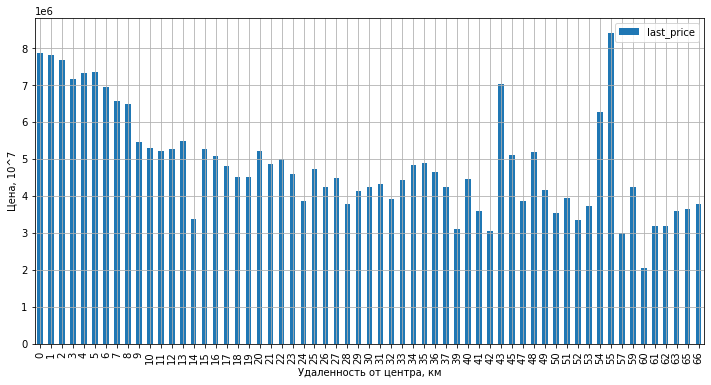

In [45]:
df['city_centers_nearest_km'] = round(df['city_centers_nearest'] / 1000)

df['city_centers_nearest_km'] = df['city_centers_nearest_km'].astype('int')

iqr = df['days_exposition'].quantile([0.25,0.5,0.75])[0.75] - df['days_exposition'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df[ (df['days_exposition'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df['days_exposition']) \
   & (df['days_exposition'] < df['days_exposition'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]

iqr = df['last_price'].quantile([0.25,0.5,0.75])[0.75] - df['last_price'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df_in_iqr[ (df_in_iqr['last_price'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df_in_iqr['last_price']) \
   & (df_in_iqr['last_price'] < df_in_iqr['last_price'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]

iqr = df['total_area'].quantile([0.25,0.5,0.75])[0.75] - df['total_area'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df_in_iqr[ (df_in_iqr['total_area'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df_in_iqr['total_area']) \
   & (df_in_iqr['total_area'] < df_in_iqr['total_area'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]

iqr = df['rooms'].quantile([0.25,0.5,0.75])[0.75] - df['rooms'].quantile([0.25,0.5,0.75])[0.25]

df_in_iqr = df_in_iqr[ (df_in_iqr['rooms'].quantile([0.25,0.5,0.75])[0.25] - 1.5 * iqr < df_in_iqr['rooms']) \
   & (df_in_iqr['rooms'] < df_in_iqr['rooms'].quantile([0.25,0.5,0.75])[0.75] + 1.5 * iqr)]


bar_km = df_in_iqr.pivot_table(index = 'city_centers_nearest_km', values = 'last_price', aggfunc = ['mean', 'count']).plot.bar(y = 'mean', figsize=(12, 6), grid = True)
plt.xlabel('Удаленность от центра, км'); 
plt.ylabel('Цена, 10^7'); 

Цена на графике начинает резко убывать на значении 9, то есть центральной зоной считается все в радиусе 9 км.

### Сегмент квартир в центре <a class="anchor" id="Сегмент-квартир-в-центре"></a>

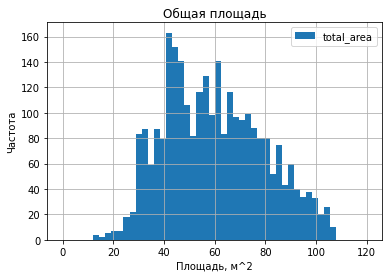

In [46]:
df_center = df_in_iqr.query('city_centers_nearest_km < 10')
df_center.plot(kind = 'hist', y = 'total_area', grid = True, bins = 50, range = (0, 120), title = 'Общая площадь');
plt.xlabel('Площадь, м^2'); 
plt.ylabel('Частота'); 
plt.show();

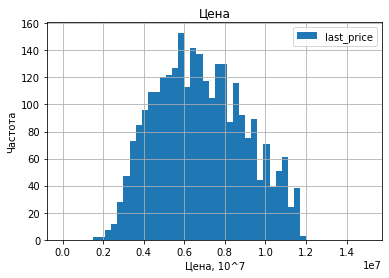

In [47]:
df_center.plot(kind = 'hist', y = 'last_price', grid = True, bins = 50, range = (0, 1.5e7), title = 'Цена');
plt.xlabel('Цена, 10^7'); 
plt.ylabel('Частота'); 
plt.show();

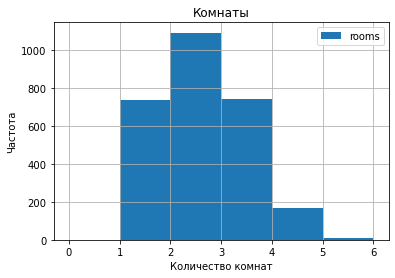

In [48]:
df_center.plot(kind = 'hist', y = 'rooms', grid = True, bins = 6, range = (0, 6), title = 'Комнаты');
plt.xlabel('Количество комнат'); 
plt.ylabel('Частота'); 
plt.show();

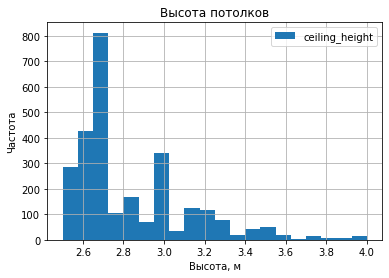

In [49]:
df_center.plot(kind = 'hist', y = 'ceiling_height', grid = True, bins = 20, range = (2.5, 4), title = 'Высота потолков');
plt.xlabel('Высота, м'); 
plt.ylabel('Частота'); 
plt.show();

Графики площади, цены, числа комнат и высоты потолков практически идентичны, и во всей таблице, но нет правой части, которая содержала выбросы, поэтому распределение цен больше похоже на нормальное. Единственное существенное отличие - в центре намного меньше однокомнатных квартир.

In [50]:
df_center[['last_price', 'total_area', 'rooms', 'city_centers_nearest']].corr()

,last_price,total_area,rooms,city_centers_nearest
last_price,1.000000,0.738239,0.471459,-0.288658
total_area,0.738239,1.000000,0.792662,-0.251594
rooms,0.471459,0.792662,1.000000,-0.199542
city_centers_nearest,-0.288658,-0.251594,-0.199542,1.000000


Корреляционная таблица сегмента очень похожа на таблицу для всех данных.

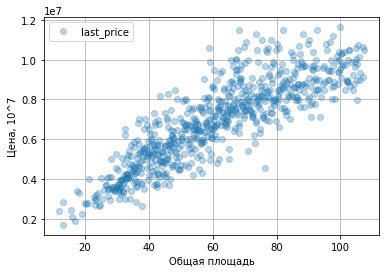

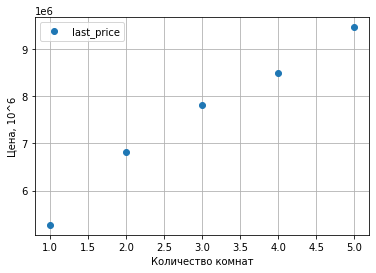

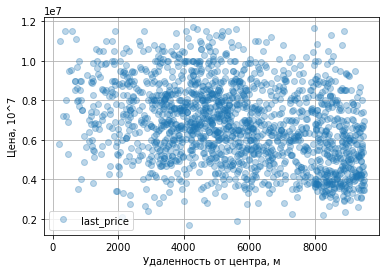

In [51]:
df_center.pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'mean').plot(style = 'o',  grid=True, alpha = 0.3);
plt.xlabel('Общая площадь'); 
plt.ylabel('Цена, 10^7'); 
df_center.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'mean').plot(style = 'o',  grid=True);
plt.xlabel('Количество комнат'); 
plt.ylabel('Цена, 10^6'); 
df_center.pivot_table(index = 'city_centers_nearest', values = 'last_price', aggfunc = 'mean').plot(style = 'o',  grid=True, alpha = 0.3);
plt.xlabel('Удаленность от центра, м'); 
plt.ylabel('Цена, 10^7'); 

Все графики очень похожи, кроме последнего: теперь удаленность от центра не так сильно влияет на цену, так как вся недвижимость находится в пределах центральной зоны.

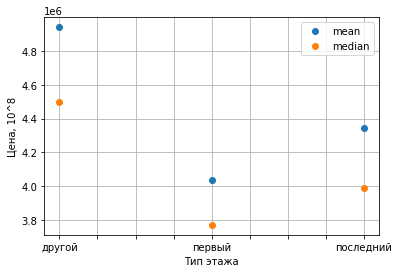

In [52]:
df_in_iqr.pivot_table(index = 'floor_names', values = 'last_price', aggfunc = ['mean', 'median']).plot(style = 'o',  grid=True);
plt.legend(['mean', 'median'])
plt.xlabel('Тип этажа'); 
plt.ylabel('Цена, 10^8'); 

Как и в общей таблице, первые этажи стоят меньше всего.

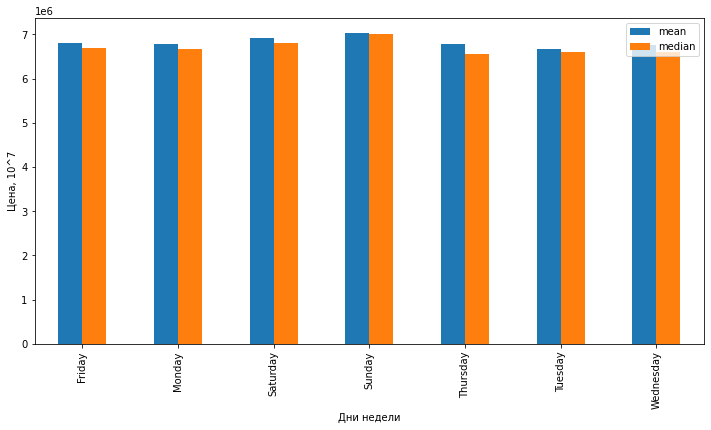

In [53]:
bar_day_center = df_center.pivot_table(index = 'exposition_day_name', values = 'last_price', aggfunc = ['mean', 'median']).plot.bar(y=['mean', 'median'], figsize=(12, 6), label = ['mean', 'median'])
plt.xlabel('Дни недели'); 
plt.ylabel('Цена, 10^7'); 

Среднее значение цены из объявления, выставленного в выходные больше, чем в остальные дни.

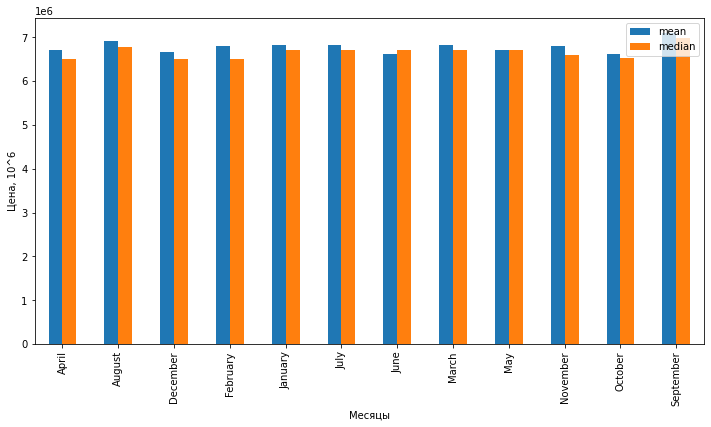

In [54]:
bar_month_center = df_center.pivot_table(index = 'exposition_month_name', values = 'last_price', aggfunc = ['median', 'mean']).plot.bar(y=['mean', 'median'], figsize=(12, 6), label = ['mean', 'median'])
plt.xlabel('Месяцы'); 
plt.ylabel('Цена, 10^6'); 

Среднее значение цены в августе и сентябре выше, чем в другие месяцы.

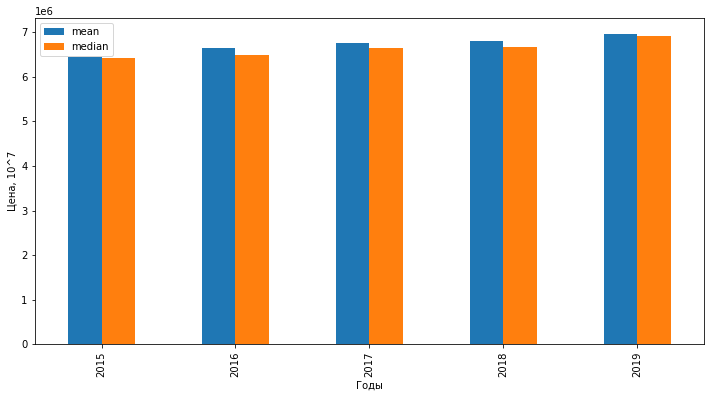

In [55]:
bar_year_center = df_center.pivot_table(index = 'exposition_year', values = 'last_price', aggfunc = ['median', 'mean']).plot.bar(y=['mean', 'median'], figsize=(12, 6), label = ['mean', 'median'])
plt.xlabel('Годы'); 
plt.ylabel('Цена, 10^7'); 

С 2015 по 2019 среднее и медианное значения цены постепенно росло.

### Вывод <a class="anchor" id="Вывод-4"></a>

В исследовательской части анализа можно сделать следующие выводы: 
* основные гистограммы (площадь, цена, и т.д. ) имеют вид распределения Пуассона, то есть высокие значения в начале, а после определенного значения идут на спад.
* квартиры чаще всего продаются за 1-3 месяца, а большинство из них - менее, чем за 434 дня.
* Больше всего на стоимость влияет площадь и количество комнат, немного влияет удаленность от центра. Недвижимость на первых этажах всегда дешевле, чем на остальных. Также по выходным, в апреле и сентябре, в 2019 году средняя цена выше, чем в остальных случаях.
* Самая дорогая недвижимость в Санкт-Петербурге, самая дешевая - в Выборге.
* Центральная зона считается в пределах 9 км от центра. Факторы, влияющие на цену всех квартир в этой зоне практически не отличаются от общих выводов по всему городу, за исключением фактора удаленности от центра, так как все квартиры и так находятся в центре.


## Общий вывод <a class="anchor" id="Общий-вывод"></a>

* Предварительный анализ таблицы, показал наличие большого количества пропусков. Используя различные методы замены пропусков, получилось устранить большинство из них. Также в некоторых столбцах необходимо было поменять тип данных для удобства.
* Для дальнейшего исследовательского анализа, потребовалось добавить в таблицу новые столбцы с дополняющими значениями.
* В процессе исследовательского анализа данных удалось выяснить, какие факторы влияют на цену недвижимости, а какие - нет, когда лучше идут продажи и где находятся самая дорогая и дешевая недвижимости.